In [1]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.special import gammaln
from scipy.integrate import quad
import matplotlib.pyplot as plt
import seaborn as sns

from utils.metrics import (
    threshold_at_completeness_of,
    threshold_at_purity_of,
    bayes_conf
)

plt.rc('legend', fontsize=10)

In [2]:
df = pd.read_csv("sdss_test.csv")
mag_r = df["dered_r"].values

In [3]:
morph_true, morph_pred = np.loadtxt('sdss_tpc.2.mlz', unpack=True, usecols=(0, 2))

In [4]:
phot_true, phot_pred = np.loadtxt('sdss_tpc.3.mlz', unpack=True, usecols=(0, 2))

In [5]:
cnn_true = np.load("sdss_test_labels.npy")
cnn_pred = np.load("sdss_convnet_pred.npy")

cnn_true = (cnn_true + 1) / 2 # make galaxy=0 and star=1

assert cnn_true.min() == 0
assert cnn_true.max() == 1
assert phot_true.sum() == cnn_true.sum()
assert morph_true.sum() == cnn_true.sum()

In [6]:
mask = ((mag_r > -90) & (mag_r < 90))
mag_r, cnn_true, cnn_pred, phot_pred, morph_pred = map(
    lambda x: x[mask],
    [mag_r, cnn_true, cnn_pred, phot_pred, morph_pred]
)

In [11]:
bins = np.arange(17, 23.5, 0.5)

In [12]:
def integrated_purity(y_true, y_pred, mag, bins=None, threshold=0.5, step=0.005, tol=0.001):

    low = np.zeros_like(bins)
    med = np.zeros_like(bins)
    high = np.zeros_like(bins)

    y_class = (y_pred >= threshold).astype(int)
    
    for i, b in enumerate(bins):
        mask = (mag < b)
        k = np.sum((y_true[mask] == 1) & (y_class[mask] == 1))
        N = np.sum(y_class[mask] == 1)
        med[i] = k / N
        low[i], high[i], _ = bayes_conf(N, k, step=step, tol=tol)
    
    return low, med, high

In [13]:
def integrated_completeness(y_true, y_pred, mag, bins=None, threshold=0.5, step=0.005, tol=0.001):

    low = np.zeros_like(bins)
    med = np.zeros_like(bins)
    high = np.zeros_like(bins)
    
    y_class = (y_pred >= threshold).astype(int)
    
    for i, b in enumerate(bins):
        mask = (mag < b)
        k = np.sum((y_true[mask] == 1) & (y_class[mask] == 1))
        N = np.sum(y_true[mask] == 1)
    
        if N > 0:
            med[i] = k / N
            low[i], high[i], _ = bayes_conf(N, k, step=step, tol=tol)
        else:
            low[i], med[i], high[i] = np.nan, np.nan, np.nan
            
    return low, med, high

In [19]:
cnn_cut, _ = threshold_at_completeness_of(1 - cnn_true, 1 - cnn_pred, 0.96)

cnn_g_low, cnn_g_med, cnn_g_high = integrated_purity(
    1 - cnn_true, 1- cnn_pred,
    mag=mag_r, bins=bins, threshold=cnn_cut, step=0.001
    )

Done. N = 1444, k = 1439, area: 0.683, alpha: 0.9952, beta: 0.9990
Done. N = 2636, k = 2627, area: 0.682, alpha: 0.9952, beta: 0.9975
Done. N = 3597, k = 3581, area: 0.682, alpha: 0.9945, beta: 0.9968
Done. N = 4098, k = 4080, area: 0.684, alpha: 0.9947, beta: 0.9969
Done. N = 4804, k = 4785, area: 0.684, alpha: 0.9951, beta: 0.9969
Done. N = 5594, k = 5570, area: 0.683, alpha: 0.9950, beta: 0.9968
Done. N = 6435, k = 6405, area: 0.683, alpha: 0.9945, beta: 0.9963
Done. N = 8278, k = 8239, area: 0.683, alpha: 0.9945, beta: 0.9960
Done. N = 10000, k = 9944, area: 0.684, alpha: 0.9937, beta: 0.9953
Done. N = 10523, k = 10449, area: 0.682, alpha: 0.9922, beta: 0.9938
Done. N = 10635, k = 10547, area: 0.683, alpha: 0.9907, beta: 0.9926
Done. N = 10652, k = 10562, area: 0.683, alpha: 0.9907, beta: 0.9925
Done. N = 10654, k = 10563, area: 0.683, alpha: 0.9906, beta: 0.9924


In [20]:
morph_cut, _ = threshold_at_completeness_of(1 - morph_true, 1 - morph_pred, 0.96)

morph_g_low, morph_g_med, morph_g_high = integrated_purity(
    1 - morph_true, 1- morph_pred,
    mag=mag_r, bins=bins, threshold=morph_cut, step=0.001
    )

Done. N = 1448, k = 1447, area: 1.000, alpha: 0.9990, beta: 1.0000
Done. N = 2646, k = 2644, area: 1.000, alpha: 0.9990, beta: 1.0000
Done. N = 3606, k = 3603, area: 1.000, alpha: 0.9990, beta: 1.0000
Done. N = 4106, k = 4103, area: 1.000, alpha: 0.9990, beta: 1.0000
Done. N = 4817, k = 4813, area: 1.000, alpha: 0.9990, beta: 1.0000
Done. N = 5617, k = 5612, area: 1.000, alpha: 0.9990, beta: 1.0000
Done. N = 6481, k = 6473, area: 1.000, alpha: 0.9984, beta: 1.0000
Done. N = 8365, k = 8349, area: 0.683, alpha: 0.9975, beta: 0.9985
Done. N = 10090, k = 10066, area: 0.683, alpha: 0.9972, beta: 0.9982
Done. N = 10539, k = 10515, area: 0.683, alpha: 0.9973, beta: 0.9982
Done. N = 10589, k = 10565, area: 0.684, alpha: 0.9973, beta: 0.9983
Done. N = 10590, k = 10566, area: 0.683, alpha: 0.9973, beta: 0.9983
Done. N = 10590, k = 10566, area: 0.683, alpha: 0.9973, beta: 0.9983


In [21]:
phot_cut, _ = threshold_at_completeness_of(1 - phot_true, 1 - phot_pred, 0.96)

phot_g_low, phot_g_med, phot_g_high = integrated_purity(
    1 - phot_true, 1- phot_pred,
    mag=mag_r, bins=bins, threshold=phot_cut, step=0.001
    )

Done. N = 1406, k = 1399, area: 0.683, alpha: 0.9932, beta: 0.9971
Done. N = 2569, k = 2557, area: 0.683, alpha: 0.9939, beta: 0.9967
Done. N = 3505, k = 3485, area: 0.684, alpha: 0.9932, beta: 0.9959
Done. N = 4000, k = 3969, area: 0.683, alpha: 0.9910, beta: 0.9940
Done. N = 4699, k = 4662, area: 0.683, alpha: 0.9907, beta: 0.9934
Done. N = 5485, k = 5430, area: 0.683, alpha: 0.9887, beta: 0.9914
Done. N = 6337, k = 6258, area: 0.683, alpha: 0.9861, beta: 0.9889
Done. N = 8307, k = 8188, area: 0.682, alpha: 0.9847, beta: 0.9874
Done. N = 10150, k = 9986, area: 0.683, alpha: 0.9825, beta: 0.9850
Done. N = 10668, k = 10476, area: 0.684, alpha: 0.9810, beta: 0.9838
Done. N = 10746, k = 10551, area: 0.683, alpha: 0.9810, beta: 0.9839
Done. N = 10756, k = 10561, area: 0.683, alpha: 0.9809, beta: 0.9837
Done. N = 10757, k = 10562, area: 0.684, alpha: 0.9809, beta: 0.9837


In [22]:
cnn_p_cut = 0.60463386

cnn_s_low, cnn_s_med, cnn_s_high = integrated_completeness(
    cnn_true, cnn_pred,
    mag=mag_r, bins=bins, threshold=cnn_cut, step=0.005
    )

Done. N = 1006, k = 976, area: 0.683, alpha: 0.9655, beta: 0.9765
Done. N = 1387, k = 1346, area: 0.682, alpha: 0.9660, beta: 0.9752
Done. N = 1814, k = 1749, area: 0.682, alpha: 0.9600, beta: 0.9692
Done. N = 2189, k = 2103, area: 0.684, alpha: 0.9573, beta: 0.9660
Done. N = 2581, k = 2482, area: 0.683, alpha: 0.9589, beta: 0.9669
Done. N = 2905, k = 2791, area: 0.684, alpha: 0.9577, beta: 0.9650
Done. N = 3211, k = 3085, area: 0.683, alpha: 0.9579, beta: 0.9650
Done. N = 3512, k = 3349, area: 0.682, alpha: 0.9509, beta: 0.9584
Done. N = 3789, k = 3562, area: 0.684, alpha: 0.9368, beta: 0.9446
Done. N = 3936, k = 3648, area: 0.682, alpha: 0.9232, beta: 0.9316
Done. N = 3982, k = 3670, area: 0.684, alpha: 0.9175, beta: 0.9262
Done. N = 3994, k = 3680, area: 0.683, alpha: 0.9186, beta: 0.9281
Done. N = 3997, k = 3682, area: 0.682, alpha: 0.9180, beta: 0.9271


In [23]:
morph_cut, _ = threshold_at_purity_of(morph_true, morph_pred, 0.97)

morph_s_low, morph_s_med, morph_s_high = integrated_completeness(
    morph_true, morph_pred,
    mag=mag_r, bins=bins, threshold=morph_cut, step=0.005
    )

Done. N = 1006, k = 1004, area: 1.000, alpha: 0.9950, beta: 1.0000
Done. N = 1387, k = 1384, area: 1.000, alpha: 0.9950, beta: 1.0000
Done. N = 1814, k = 1809, area: 1.000, alpha: 0.9950, beta: 1.0000
Done. N = 2189, k = 2184, area: 1.000, alpha: 0.9950, beta: 1.0000
Done. N = 2581, k = 2574, area: 1.000, alpha: 0.9950, beta: 1.0000
Done. N = 2905, k = 2895, area: 1.000, alpha: 0.9950, beta: 1.0000
Done. N = 3211, k = 3195, area: 1.000, alpha: 0.9960, beta: 1.0000
Done. N = 3512, k = 3477, area: 0.683, alpha: 0.9887, beta: 0.9923
Done. N = 3789, k = 3726, area: 0.684, alpha: 0.9816, beta: 0.9859
Done. N = 3936, k = 3860, area: 0.683, alpha: 0.9792, beta: 0.9874
Done. N = 3982, k = 3906, area: 0.682, alpha: 0.9790, beta: 0.9834
Done. N = 3994, k = 3918, area: 0.684, alpha: 0.9787, beta: 0.9831
Done. N = 3997, k = 3921, area: 0.682, alpha: 0.9792, beta: 0.9837


In [24]:
phot_cut, _ = threshold_at_purity_of(phot_true, phot_pred, 0.97)

phot_s_low, phot_s_med, phot_s_high = integrated_completeness(
    phot_true, phot_pred,
    mag=mag_r, bins=bins, threshold=phot_cut, step=0.005
    )

Done. N = 1006, k = 965, area: 0.684, alpha: 0.9535, beta: 0.9661
Done. N = 1387, k = 1328, area: 0.682, alpha: 0.9518, beta: 0.9626
Done. N = 1814, k = 1727, area: 0.683, alpha: 0.9482, beta: 0.9589
Done. N = 2189, k = 2076, area: 0.683, alpha: 0.9437, beta: 0.9531
Done. N = 2581, k = 2439, area: 0.683, alpha: 0.9400, beta: 0.9500
Done. N = 2905, k = 2703, area: 0.684, alpha: 0.9269, beta: 0.9370
Done. N = 3211, k = 2947, area: 0.683, alpha: 0.9132, beta: 0.9230
Done. N = 3512, k = 3176, area: 0.683, alpha: 0.9002, beta: 0.9104
Done. N = 3789, k = 3390, area: 0.683, alpha: 0.8899, beta: 0.8999
Done. N = 3936, k = 3497, area: 0.684, alpha: 0.8844, beta: 0.8948
Done. N = 3982, k = 3537, area: 0.682, alpha: 0.8829, beta: 0.8929
Done. N = 3994, k = 3547, area: 0.683, alpha: 0.8829, beta: 0.8929
Done. N = 3997, k = 3549, area: 0.683, alpha: 0.8829, beta: 0.8929


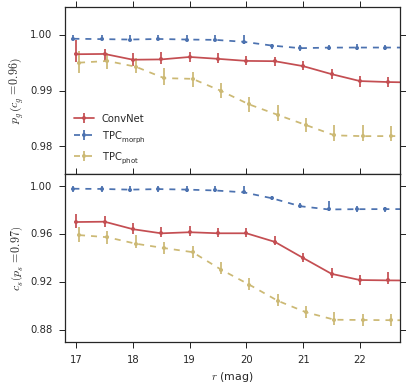

In [43]:
p = sns.color_palette()
sns.set_style("ticks")

fig = plt.figure(figsize=(6, 6))

ax0 = plt.subplot2grid((6, 3), (0, 0), colspan=3, rowspan=3)
ax1 = plt.subplot2grid((6, 3), (3, 0), colspan=3, rowspan=3)

plt.setp(ax0.get_xticklabels(), visible=False)

offset = 0.05

ax0.errorbar(
    bins, cnn_g_med,
    yerr=[cnn_g_med - cnn_g_low, cnn_g_high - cnn_g_med],
    label='ConvNet', ls='-', marker='o', markersize=4, color=p[2])

ax0.errorbar(
    bins - offset, morph_g_med,
    yerr=[morph_g_med - morph_g_low, morph_g_high - morph_g_med],
    label='$\mathregular{TPC_{morph}}$', ls='--', marker='o', markersize=4, color=p[0])

ax0.errorbar(
    bins + offset, phot_g_med,
    yerr=[phot_g_med - phot_g_low, phot_g_high - phot_g_med],
    label='$\mathregular{TPC_{phot}}$', ls='--', marker='o', markersize=4, color=p[4])

ax0.set_xlim(16.8, 22.7)
ax0.set_ylim(0.975, 1.005)
ax0.set_yticks([0.98, 0.99, 1.0])
ax0.set_ylabel(r'$p_g\left(c_g=0.96\right)$', fontsize=12)

ax0.legend(loc='lower left')

ax1.errorbar(
    bins, cnn_s_med,
    yerr=[cnn_s_med - cnn_s_low, cnn_s_high - cnn_s_med],
    label='ConvNet', ls='-', marker='o', markersize=4, color=p[2])

ax1.errorbar(
    bins - offset, morph_s_med,
    yerr=[morph_s_med - morph_s_low, morph_s_high - morph_s_med],
    label='$\mathregular{TPC_{morph}}$', ls='--', marker='o', markersize=4, color=p[0])

ax1.errorbar(
    bins + offset, phot_s_med,
    yerr=[phot_s_med - phot_s_low, phot_s_high - phot_s_med],
    label='$\mathregular{TPC_{phot}}$', ls='--', marker='o', markersize=4, color=p[4])

ax1.set_ylabel(r'$c_s\left(p_s=0.97\right)$', fontsize=12)
ax1.set_xlim(16.8, 22.7)
ax1.set_ylim(0.87, 1.01)
ax1.set_yticks([0.88, 0.92, 0.96, 1.00])

ax1.set_xlabel(r'$r$ (mag)')

plt.subplots_adjust(hspace=0)

plt.savefig('figures/sdss_integrated.pdf')

plt.show()